In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder('../data/split/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('../data/split/val', transform=val_test_transforms)
test_dataset = datasets.ImageFolder('../data/split/test', transform=val_test_transforms)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

Train: 81, Val: 16, Test: 22


In [6]:
models = {
    'resnet18': timm.create_model('resnet18', pretrained=True, num_classes=3),
    'efficientnet_b0': timm.create_model('efficientnet_b0', pretrained=True, num_classes=3)
}

In [15]:
def freeze_layers(model, model_name, num_unfrozen_layers=0):
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the FC layer based on model architecture
    if 'resnet' in model_name.lower():
        for param in model.fc.parameters():
            param.requires_grad = True
    elif 'efficientnet' in model_name.lower():
        for param in model.classifier.parameters():
            param.requires_grad = True
    
    # Optionally unfreeze additional layers
    if num_unfrozen_layers > 0:
        for param in list(model.parameters())[-num_unfrozen_layers:]:
            param.requires_grad = True

ResNet18

In [10]:
freeze_layers(models['resnet18'], num_unfrozen_layers=0)
models['resnet18'].fc.requires_grad_(True)

Linear(in_features=512, out_features=3, bias=True)

In [12]:
for param in models['resnet18'].layer4.parameters():
    param.requires_grad = True

In [23]:
def train_and_evaluate(model, train_loader, val_loader, config):
    model = model.to(config['device'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(config['epochs']):
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        for images, labels in train_loader:
            images, labels = images.to(config['device']), labels.to(config['device'])
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(config['device']), labels.to(config['device'])
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{config['epochs']}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Сохранение модели
    os.makedirs('models', exist_ok=True)
    save_path = f"models/{config['model_name']}_bs{config['batch_size']}_lr{config['lr']}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Модель сохранена: {save_path}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_labels

In [33]:
config = {'lr': lr, 'epochs': 10, 'device': device, 'model_name': model_name}

In [24]:
batch_sizes = [8, 16]
lrs = [1e-5, 1e-4]
results = {}

for model_name, model in models.items():
    for bs in batch_sizes:
        for lr in lrs:
            print(f'Обучение {model_name} с batch_size={bs}, lr={lr}')
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
            config = {'lr': lr, 'epochs': 10, 'device': device, 'model_name': model_name, 'batch_size': bs}
            freeze_layers(model, model_name, num_unfrozen_layers=0)
            print(f"Размороженные параметры для {model_name}:", [name for name, param in model.named_parameters() if param.requires_grad])
            results[f'{model_name}_bs{bs}_lr{lr}'] = train_and_evaluate(model, train_loader, val_loader, config)

Обучение resnet18 с batch_size=8, lr=1e-05
Размороженные параметры для resnet18: ['fc.weight', 'fc.bias']
Epoch 1/10: Train Loss: 0.9703, Train Acc: 0.7160, Val Loss: 1.0000, Val Acc: 0.7500
Epoch 2/10: Train Loss: 0.9637, Train Acc: 0.7901, Val Loss: 1.0019, Val Acc: 0.7500
Epoch 3/10: Train Loss: 0.9711, Train Acc: 0.8025, Val Loss: 0.9999, Val Acc: 0.7500
Epoch 4/10: Train Loss: 0.9912, Train Acc: 0.7284, Val Loss: 0.9980, Val Acc: 0.7500
Epoch 5/10: Train Loss: 0.9847, Train Acc: 0.7531, Val Loss: 0.9918, Val Acc: 0.7500
Epoch 6/10: Train Loss: 0.9662, Train Acc: 0.8519, Val Loss: 0.9952, Val Acc: 0.8125
Epoch 7/10: Train Loss: 0.9656, Train Acc: 0.8025, Val Loss: 1.0043, Val Acc: 0.6875
Epoch 8/10: Train Loss: 0.9657, Train Acc: 0.8148, Val Loss: 0.9949, Val Acc: 0.7500
Epoch 9/10: Train Loss: 0.9605, Train Acc: 0.7778, Val Loss: 0.9983, Val Acc: 0.6250
Epoch 10/10: Train Loss: 0.9720, Train Acc: 0.8025, Val Loss: 1.0037, Val Acc: 0.6875
Модель сохранена: models/resnet18_bs8_lr1e-

График сохранен: plots/resnet18_bs16_lr0.0001.png


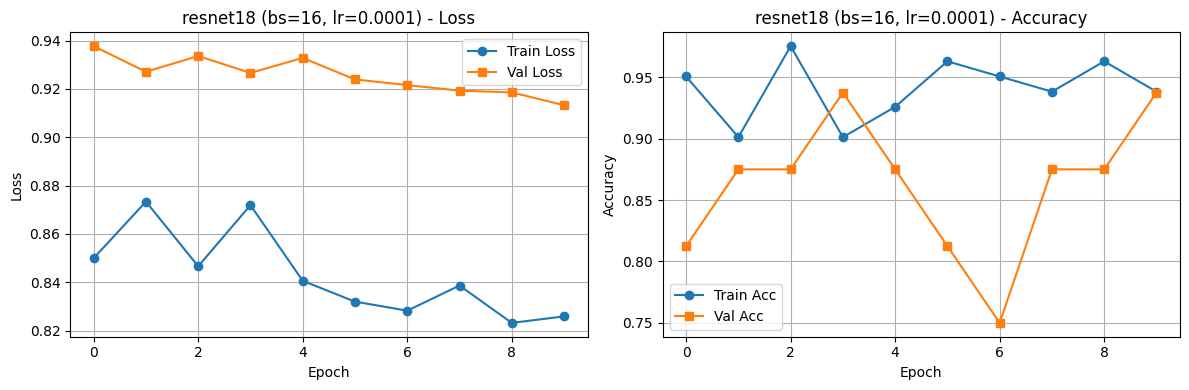

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Создаем папку для графиков
os.makedirs('plots', exist_ok=True)

def plot_learning_curves(results, model_name, batch_size, lr):
    # Извлекаем результаты для конкретной комбинации
    train_losses, val_losses, train_accuracies, val_accuracies, _, _ = results[f'{model_name}_bs{batch_size}_lr{lr}']
    
    # Создаем график
    plt.figure(figsize=(12, 4))
    
    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.title(f'{model_name} (bs={batch_size}, lr={lr}) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Val Acc', marker='s')
    plt.title(f'{model_name} (bs={batch_size}, lr={lr}) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # Сохраняем график
    save_path = f'plots/{model_name}_bs{batch_size}_lr{lr}.png'
    plt.savefig(save_path)
    print(f'График сохранен: {save_path}')
    plt.show()


bs = 16
lr = 0.0001
model_name = 'resnet18'

            
if f'{model_name}_bs{bs}_lr{lr}' in results:
    plot_learning_curves(results, model_name, bs, lr)
else:
    print(f'Результаты для {model_name}_bs{bs}_lr{lr} отсутствуют')

In [30]:
import torch
import timm
import onnx
import os

def export_to_onnx(model_name, model_path, onnx_path, input_shape=(1, 3, 224, 224), device='cpu'):
    # Загружаем модель
    model = timm.create_model(model_name, pretrained=False, num_classes=3)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Создаем фиктивный входной тензор
    dummy_input = torch.randn(input_shape).to(device)

    # Экспортируем модель в ONNX
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=18,  # Используем более новую версию opset
        do_constant_folding=True,
        input_names=['input'],  # Имя входного тензора
        output_names=['output'],  # Имя выходного тензора
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Указываем динамическую ось для batch_size
    )
    print(f"Модель экспортирована в {onnx_path}")

    # Проверяем корректность ONNX модели
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    print(f"ONNX модель проверена успешно")

# Параметры
best_model_name = 'resnet18'
best_model_path = 'models/resnet18_bs16_lr0.0001.pth'
onnx_path = f'models/{best_model_name}_bs16_lr0.0001.onnx'

# Экспорт
os.makedirs('models', exist_ok=True)
export_to_onnx(best_model_name, best_model_path, onnx_path, device='cpu')

C:\Users\Дарья\AppData\Local\Temp\ipykernel_10192\2609109077.py:17: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Модель экспортирована в models/resnet18_bs16_lr0.0001.onnx
ONNX модель проверена успешно
